In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import gymnasium as gym

import warnings
warnings.filterwarnings('ignore')

# Agent

In [2]:
class QLearningAgent:
    """
    Class for an agent based on tabular Q-Learning working in a gymnasiym 0.29.1 environment
    
    """
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon, epsilon_decay, epsilon_min, n_episodes):
        self.q_table=np.zeros((n_states, n_actions))
        self.alpha=alpha
        self.gamma=gamma
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.epsilon_min=epsilon_min
        self.n_episodes=n_episodes

    def run_episode(self, env, train=True):
        """
        Runs one episode of interaction between agent and environment
        
        Parameters
        ----------
        env: gymnasium environment
        train: bool
            updates Q table if True
            
        Returns
        -------
        total_reward: float
            total accumulated reward for the episode
        """
        full_state = env.reset()
        # get state from environment reset
        state = full_state[0]  
        done = False
        total_reward = 0

        while not done:
            # exploration with epsilon-greedy strategy or exploitation
            if train and np.random.uniform(0, 1) < self.epsilon:
                action = env.action_space.sample()
            else:
                # take into the case when several q values are the same
                # in such a case np.argmax would return the first occurence
                # instead choose a random action from the maximum ones
                max_q_value = np.max(self.q_table[state])
                max_actions = np.where(self.q_table[state] == max_q_value)[0]
                action = np.random.choice(max_actions)

            next_state, reward, terminated, truncated, _ = env.step(action)
            # accumulate reward
            total_reward += reward

            if train:
                # update Q-table
                old_value = self.q_table[state, action]
                next_max = np.max(self.q_table[next_state])
                new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
                self.q_table[state, action] = new_value

            state = next_state
            done = terminated or truncated
        return total_reward


    def train(self, env, verbose):
        """
        Runs training of agent for n_episodes times
        
        Parameters
        ----------
        env: gymnasium environment
        verbose: bool
            prints training results if True
        
        Returns
        -------
        rewards: list
            list of total accumulated rewards for each episode
        """
        rewards = []
        for episode in tqdm(range(self.n_episodes)):
            total_reward = self.run_episode(env)
            rewards.append(total_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            if verbose and (episode + 1) % 100 == 0:
                print(f"Episode: {episode + 1}, Average Reward: {np.mean(rewards[-100:])}")
        if verbose:
            print("Training completed")
        return rewards

# Training with different parameters

In [3]:
params_dict = {
    "v1": {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.1, "epsilon_decay": 0.99, "epsilon_min": 0.01},
    "v2": {"alpha": 0.5, "gamma": 0.9, "epsilon": 0.1, "epsilon_decay": 0.99, "epsilon_min": 0.01},
    "v3": {"alpha": 0.9, "gamma": 0.9, "epsilon": 0.1, "epsilon_decay": 0.99, "epsilon_min": 0.01},
    "v4": {"alpha": 0.1, "gamma": 0.5, "epsilon": 0.1, "epsilon_decay": 0.99, "epsilon_min": 0.01},
    "v5": {"alpha": 0.1, "gamma": 0.1, "epsilon": 0.1, "epsilon_decay": 0.99, "epsilon_min": 0.01},
    "v6": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "epsilon_decay": 0.99, "epsilon_min": 0.},
    "v7": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.5, "epsilon_decay": 0.99, "epsilon_min": 0.},
    "v8": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "epsilon_decay": 0.999999, "epsilon_min": 0.},
}

In [4]:
env = gym.make('Taxi-v3')
n_states = env.observation_space.n
n_actions = env.action_space.n

In [8]:
train_results = {}

for version, params in params_dict.items():
    agent = QLearningAgent(
        n_states, n_actions, 
        alpha=params["alpha"],
        gamma=params["gamma"],
        epsilon=params["epsilon"],
        epsilon_decay=params["epsilon_decay"],
        epsilon_min=params["epsilon_min"],
        n_episodes=5000
    )
    train_results[version] = agent.train(env, verbose=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Visulalization

In [11]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def plot_rewards(rewards, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
    ma_rewards = moving_average(rewards)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

    ax[0].plot(rewards)
    ax[1].plot(np.arange(len(ma_rewards)) + 100, ma_rewards)

    ax[0].grid()
    ax[1].grid()

    ax[0].set_title("Total rewards for an episode")
    ax[1].set_title("Rolling average reward for 100 previous episodes")

    fig.suptitle(f"{version} | alpha={alpha}, gamma={gamma}, epsilon={epsilon}, epsilon_decay={epsilon_decay}, epsilon_min={epsilon_min}")
    plt.show()

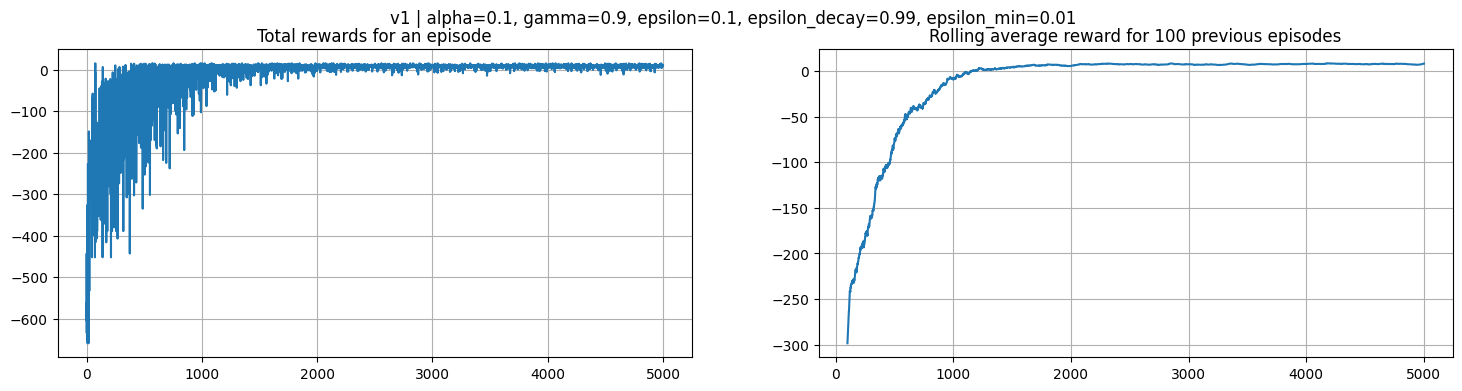

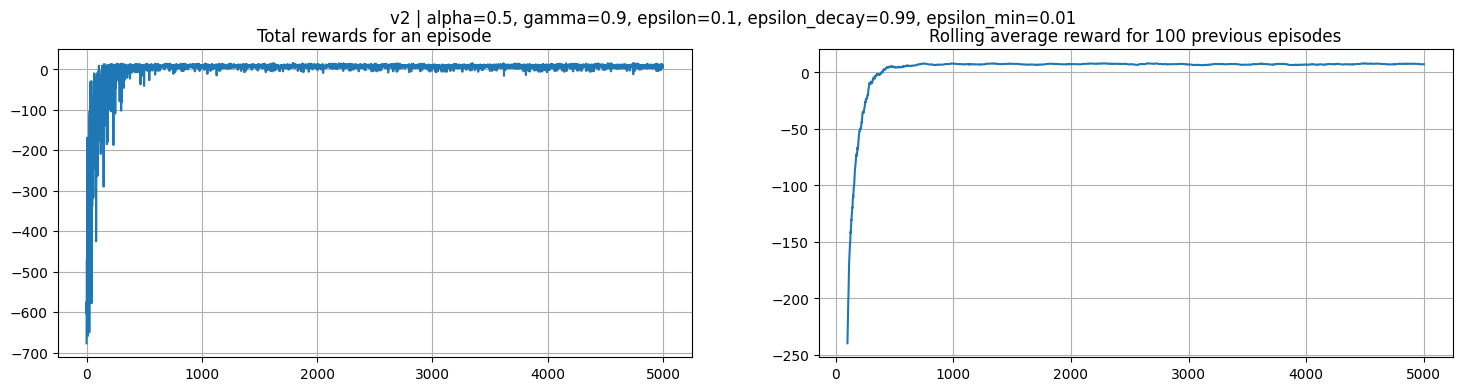

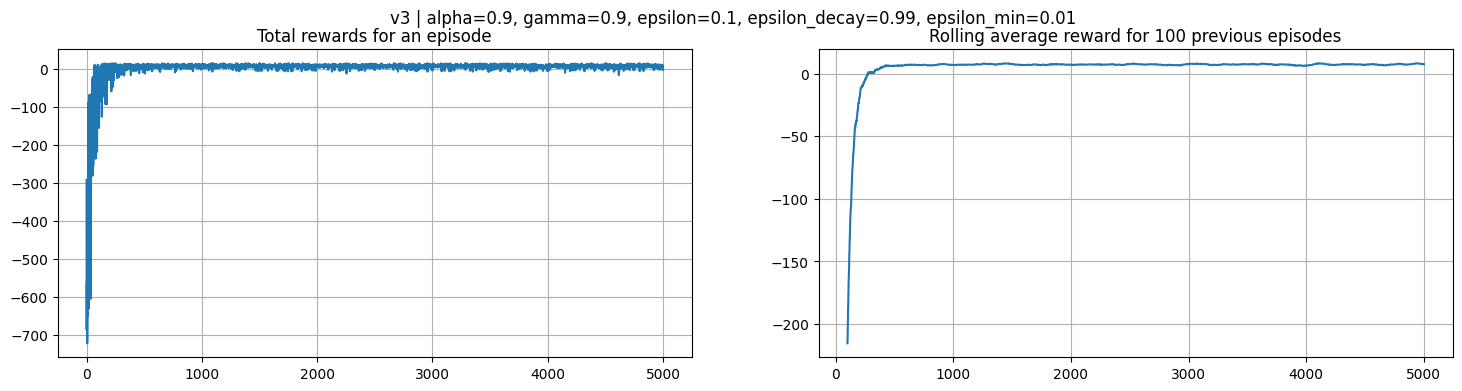

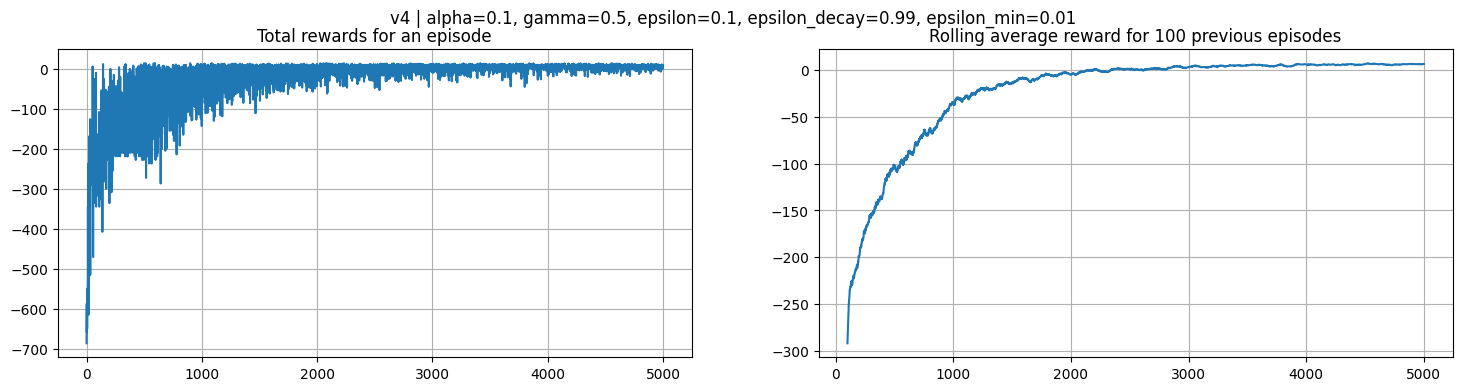

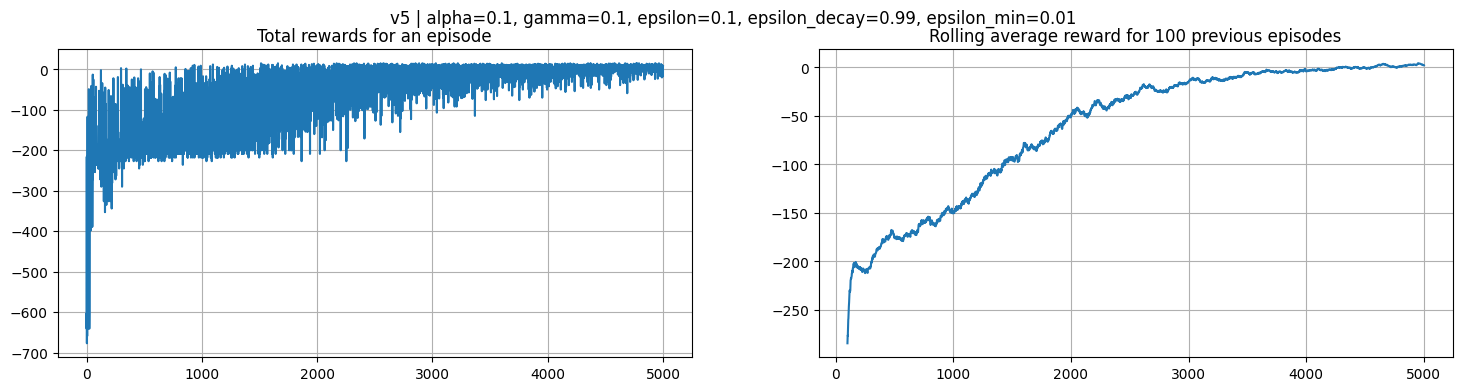

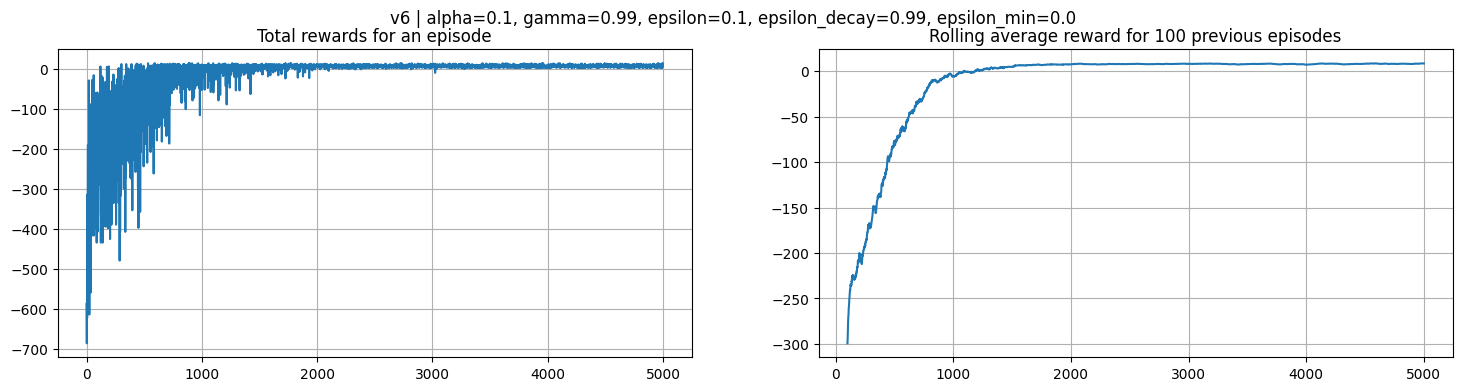

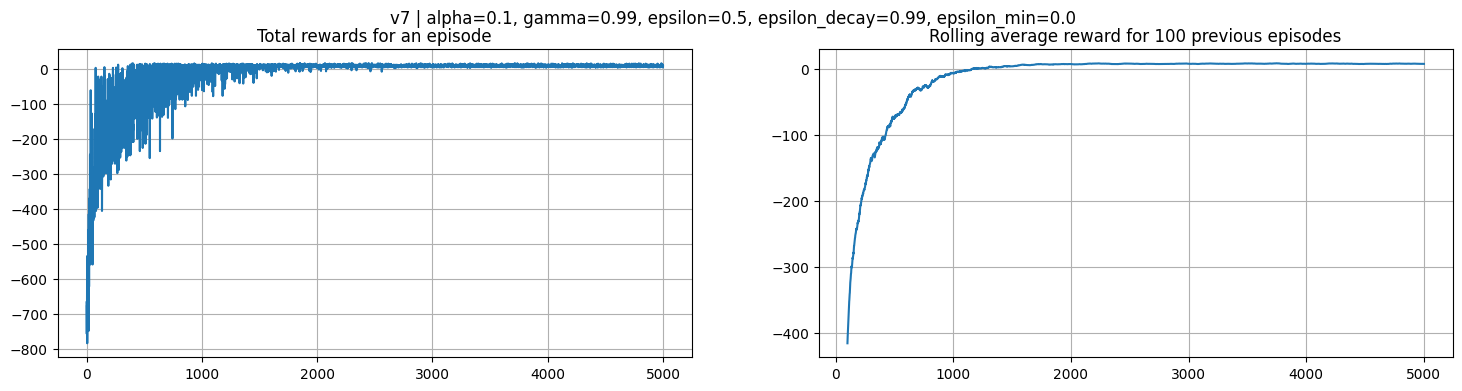

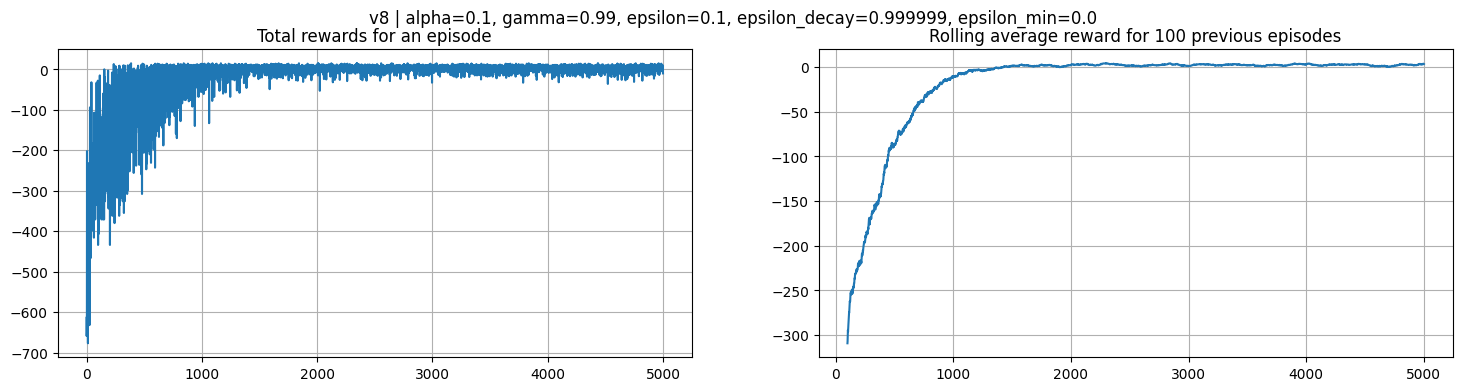

In [12]:
for version, rewards in train_results.items():
    params = params_dict[version]
    plot_rewards(rewards, alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"], epsilon_decay=params["epsilon_decay"], epsilon_min=params["epsilon_min"])